# Acessibility Analysis
cite: Morelli, A. B., & Cunha, A. L. (2021). Assessing vulnerabilities in transport networks: a graph-theoretic approach. TRANSPORTES, 29(1), 161–172.
https://doi.org/10.14295/transportes.v29i1.2250

In [1]:
import osmnx as ox
import geopandas as gpd
import tools.accessibility as acc
import tools.plotting as fjp

import matplotlib.pyplot as plt

In [2]:
# for accessibility analysis, we need more than graph data

# Monte Alto Census Tracts:
tracts = gpd.read_file('test_data/MonteAlto-Tracts.gpkg')
# take only urban sectors
tracts = tracts[tracts['TIPO']=='URBANO']
tracts = tracts.to_crs('epsg:4326')

# Monte Alto Census Points Of Interest:
pois = gpd.read_file('test_data/MonteAlto-Pois.gpkg')
# we only keep info on commercial facilities:
pois = pois[pois['outros']>0]
pois = pois.to_crs('epsg:4326')

C:\Users\andre\anaconda3\lib\site-packages\geopandas\geodataframe.py:578: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


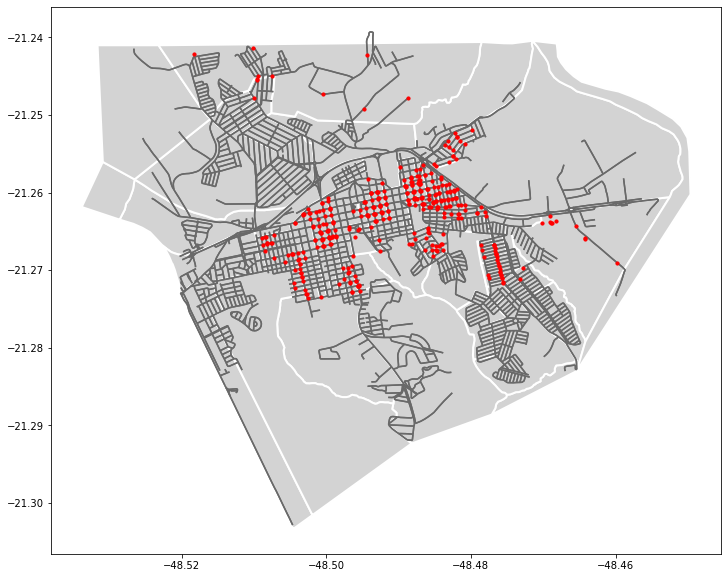

In [3]:
#Get graph from census geometry:
G = ox.graph_from_polygon(tracts.unary_union, network_type='walk')
edges = ox.graph_to_gdfs(G,nodes=False)

ax = edges.plot(color='dimgrey',zorder=1,figsize=(12,12))
ax = pois.plot(color='r',zorder=3,ax=ax,markersize=10)
tracts.plot(color='lightgrey',edgecolor='w',linewidth=2,zorder=0,figsize=(15,15),ax=ax)
plt.show()

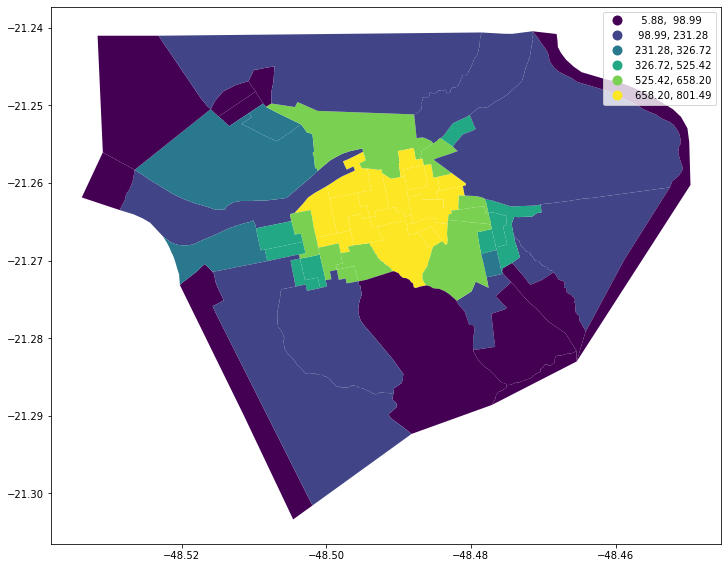

In [4]:
# calculate accessibility for each census tract
accessibility = acc.calc_accessibility(tracts,G,pois=pois,k=10,
                                         # weight the destinations by number of 
                                         # commercial facilities on the POI
                                         pois_weight_column='outros',
                                         # use cumulative gaussian as funciton
                                         func=acc.acc_cumulative_gaussian,
                                         # set function param to 400m walk dist:
                                         func_kws={'t':2000})
#set it as column in gdf
tracts['accessibility']=accessibility.values()
tracts.plot(column='accessibility',figsize=(12,12),
            legend=True,scheme='fisherjenks',k=6)
plt.show()

# Betweenness Accessibility

Betweenness accessibility was first proposed by Sarlas *et al.* (2020) in https://doi.org/10.1016/j.jtrangeo.2020.102680. We are going to use it to find the critical infrastructure in the city.


First we calculate the path matrix and then use it to calculate betweenness accessibility

In [5]:
# calculate betweenness accessibility for each edge on the graph
path_mat = acc.betweenness_accessibility(tracts,G,pois=pois,k=10,
                                       # weight the destinations by number of 
                                       # commercial facilities on the POI
                                       pois_weight_column='outros',
                                       # use cumulative gaussian as funciton
                                       func=acc.acc_cumulative_gaussian,
                                       # set function param to 400m walk dist:
                                       func_kws={'t':2000})

# add edges to graph
acc.add_edge_loads(G,path_mat)
edges = ox.graph_to_gdfs(G,nodes=False)

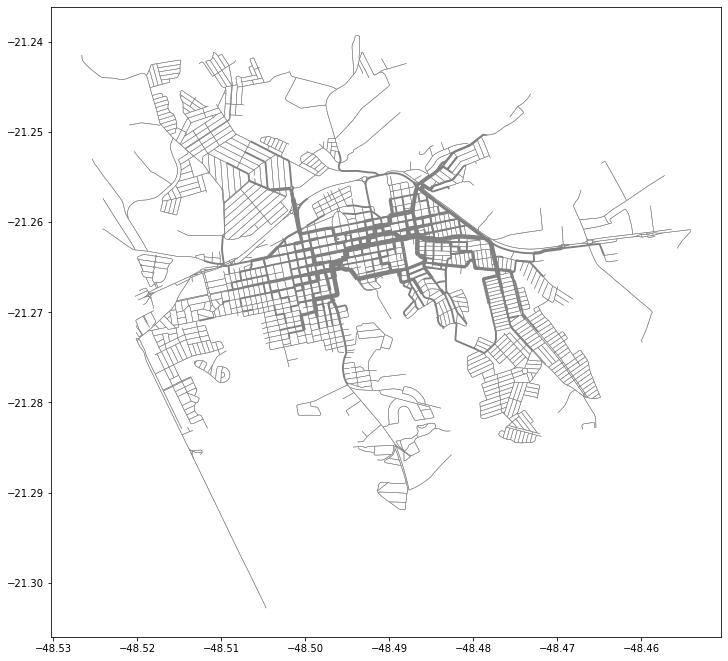

In [6]:
# plot results
sizes = fjp.linewidths_by_attribute_fisherjenks(edges,'load') #needs mapclassify
ax=edges.plot(color='grey',figsize=(12,12), linewidth=sizes,k=8)
plt.show()

### Now we can focus the analysis to the Northwest region of the city which has a relativelly high concentration of people, but very low accessibility.

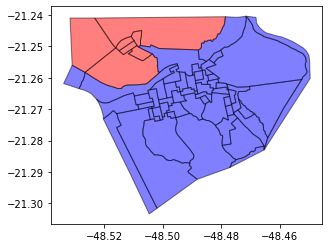

In [7]:
#focus on nortwest region
tracts.plot(column='Northwest',cmap='bwr',alpha=.5,edgecolor='k')
plt.show()

In [8]:
# add edges to graph
area_mask = tracts[tracts['Northwest']].index
acc.add_edge_loads(G,path_mat,filter_areas=area_mask,name='NWload')
edges = ox.graph_to_gdfs(G,nodes=False)

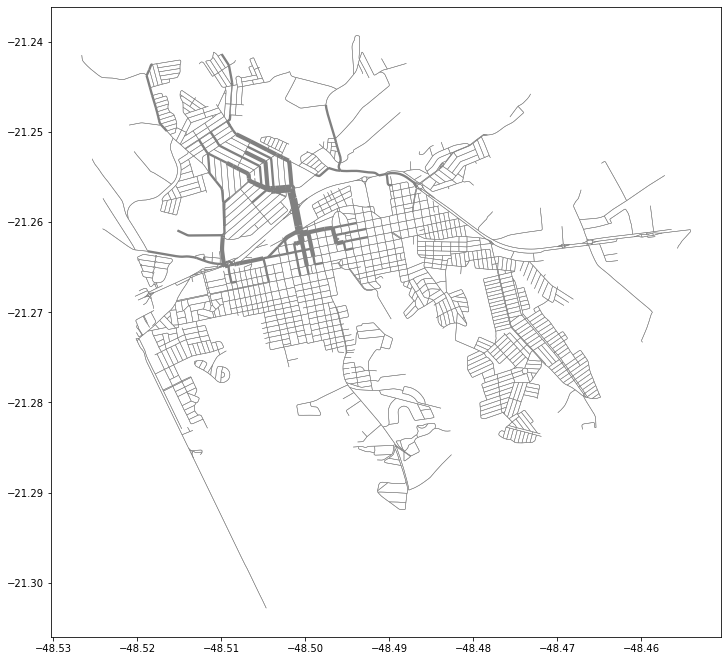

In [9]:
# plot results
sizes = fjp.linewidths_by_attribute_fisherjenks(edges,'NWload',k=4) #needs mapclassify
ax=edges.plot(color='grey',figsize=(12,12), linewidth=sizes,k=8)
plt.show()

### We can see how the overpasses crossing the highway assume most of the importance of the network for this region. This is indicative that the residents of the Northwest section are forced to rely on motor vehicles/transit or risk a dangerous path through the overpass to access most facilities.

*A cookie for the one who guesses which part of the city is the fastest growing*